# Analisis Sentimen Review Pengguna Aplikasi Duolingo di Play Store Menggunakan Machine Learning
**Nama : Diva Anggreini Harahap** <br>
**ID : MC319D5X2329**

## **Load Dataset**

### Import Library

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
import string
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import csv
import requests
from io import StringIO
from wordcloud import WordCloud
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from collections import Counter

### Load Dataset

In [3]:
data = pd.read_csv('review_duolingo.csv')
data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,0e5259f4-055a-4548-bc33-75d53b7977fc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,apk ini sangat bagus dan membantu untuk belaja...,3,1,6.25.4,2025-04-10 12:58:00,NaN,NaN,6.25.4
1,e2f54c77-0551-43e5-aab7-60f5cb953713,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,untuk aplikasi nya seruu dan muda untuk di pah...,4,9,6.24.2,2025-04-04 05:46:54,NaN,NaN,6.24.2
2,798d3a62-9737-4161-95ef-d5d14155fcc7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Untuk aplikasi nya sangat bagus, metode pelaja...",1,56,6.22.3,2025-03-29 17:50:52,NaN,NaN,6.22.3
3,d140767b-1c9a-41e6-8612-9b697fbf3e01,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sebelumnya cukup sulit untuk mengumpulkan 5 He...,5,362,6.22.3,2025-03-23 20:31:14,NaN,NaN,6.22.3
4,558f02c7-4fa5-4086-b70d-4513b23bc989,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Duolingo memang baguss polll, aku suka banget....",3,7,6.24.2,2025-04-05 12:42:35,NaN,NaN,6.24.2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              22500 non-null  object 
 1   userName              22500 non-null  object 
 2   userImage             22500 non-null  object 
 3   content               22500 non-null  object 
 4   score                 22500 non-null  int64  
 5   thumbsUpCount         22500 non-null  int64  
 6   reviewCreatedVersion  20899 non-null  object 
 7   at                    22500 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            20899 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1.9+ MB


Info dataset ini memberikan gambaran komprehensif tentang struktur dan isi dari DataFrame `data`, yang berisi total **22500 baris** dan **11 kolom**. Kolom-kolom tersebut mencakup: 
- `reviewId`: Identifikasi unik untuk setiap ulasan.
- `userName`: Nama pengguna yang memberikan ulasan.
- `userImage`: URL gambar profil pengguna.
- `content`: Teks ulasan yang diberikan oleh pengguna.
- `score`: Skor rating yang diberikan oleh pengguna.
- `thumbsUpCount`: Jumlah thumbs up yang diterima ulasan.
- `reviewCreatedVersion`: Versi aplikasi saat ulasan dibuat.
- `at`: Waktu ketika ulasan dibuat.
- `replyContent`: Balasan dari pengembang terhadap ulasan.
- `repliedAt`: Waktu ketika pengembang memberikan balasan.
- `appVersion`: Versi aplikasi yang digunakan oleh pengguna saat memberikan ulasan.

Tipe data yang digunakan bervariasi, meliputi objek (string), integer, float, dan datetime.

Beberapa kolom, seperti `replyContent` dan `repliedAt`, memiliki **seluruh nilainya kosong (null)**, menunjukkan bahwa tidak ada balasan dari pengembang terhadap ulasan-ulasan tersebut. Sementara itu, kolom `reviewCreatedVersion` dan `appVersion` memiliki sebagian nilai null, kemungkinan karena pengguna tidak menyertakan versi aplikasi saat memberikan ulasan.

Secara keseluruhan, informasi ini memberikan pemahaman awal yang penting terhadap struktur dan kelengkapan data, sehingga dapat membantu dalam proses eksplorasi dan analisis data selanjutnya.

## **Data Preparation**

Menghapus baris-baris data yang tidak memiliki nilai pada kolom 'content', karena kolom ini berisi teks ulasan dari pengguna dan sangat penting dalam analisis sentimen. Kemudian kita akan menghapus baris-baris yang isinya duplikat (identik 100%) untuk menghindari bias atau perhitungan berulang saat analisis.

In [5]:
# Jumlah data sebelum pembersihan
print(f"Jumlah data awal: {data.shape[0]} baris dan {data.shape[1]} kolom")

# Menghapus kolom yang seluruhnya kosong
data = data.dropna(axis=1, how='all')
print(f"Jumlah kolom setelah hapus yang kosong semua: {data.shape[1]} kolom")

# Menghapus baris yang nilai kolom 'content' kosong
before = data.shape[0]
data = data.dropna()
after = data.shape[0]
print(f"Jumlah baris dihapus karena missing values: {before - after}")

# Menghapus data duplikat
before = data.shape[0]
data = data.drop_duplicates()
after = data.shape[0]
print(f"Jumlah baris dihapus karena duplikat: {before - after}")

# Reset index agar rapi
data.reset_index(drop=True, inplace=True)

# Tampilkan info akhir
print("\nInformasi data setelah dibersihkan:")
data.info()


Jumlah data awal: 22500 baris dan 11 kolom
Jumlah kolom setelah hapus yang kosong semua: 9 kolom
Jumlah baris dihapus karena missing values: 1601
Jumlah baris dihapus karena duplikat: 0

Informasi data setelah dibersihkan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20899 entries, 0 to 20898
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20899 non-null  object
 1   userName              20899 non-null  object
 2   userImage             20899 non-null  object
 3   content               20899 non-null  object
 4   score                 20899 non-null  int64 
 5   thumbsUpCount         20899 non-null  int64 
 6   reviewCreatedVersion  20899 non-null  object
 7   at                    20899 non-null  object
 8   appVersion            20899 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


Dengan menghapus nilai NaN dan duplikat, dataset telah dibersihkan dan siap untuk masuk ke tahapan preprocessing teks.

In [6]:
clean_data = data.copy()
clean_data = clean_data[['content']].copy()
clean_data.head(5)

,content
0,apk ini sangat bagus dan membantu untuk belaja...
1,untuk aplikasi nya seruu dan muda untuk di pah...
2,"Untuk aplikasi nya sangat bagus, metode pelaja..."
3,sebelumnya cukup sulit untuk mengumpulkan 5 He...
4,"Duolingo memang baguss polll, aku suka banget...."


Disini, kita akan menyederhanakan dataset dan fokus pada kolom yang paling relevan yaitu `content`, yang berisi teks ulasan yang akan digunakan dalam analisis sentimen.

## **Preprocessing Text**

Langkah selanjutnya yg akan kita lakukan adalah **Preprocesing Text**. Preprocessing text adalah proses membersihkan, memproses, dan mempersiapkan teks mentah agar dapat diolah lebih lanjut dengan tepat dan akurat.

Berikut fungsi-fungsi yang akan kita gunakan :
- cleaningText(text): Membersihkan teks dengan menghapus mention, hashtag, RT (retweet), tautan (link), angka, dan tanda baca. Selain itu, karakter newline diganti dengan spasi dan spasi ekstra pada awal dan akhir teks dihapus.
- casefoldingText(text): Mengonversi semua karakter dalam teks menjadi huruf kecil (lowercase) untuk membuat teks menjadi seragam.
- tokenizingText(text): Memecah teks menjadi daftar kata atau token. Ini membantu dalam mengurai teks menjadi komponen-komponen dasar untuk analisis lebih lanjut.
- filteringText(text): Menghapus kata-kata berhenti (stopwords) dalam teks. Daftar kata-kata berhenti telah diperbarui dengan beberapa kata tambahan.
- stemmingText(text): Menerapkan stemming pada teks, yakni mengurangi kata-kata menjadi bentuk dasarnya. Anda menggunakan pustaka Sastrawi untuk melakukan stemming dalam bahasa Indonesia.
- toSentence(list_words): Menggabungkan daftar kata-kata menjadi sebuah kalimat.

In [7]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

Setelah teks dibersihkan melalui berbagai tahapan preprocessing, langkah berikutnya adalah menghapus atau mengganti kata-kata slang (informal) yang umum digunakan dalam percakapan sehari-hari, terutama di media sosial.  Tujuan utamanya adalah memastikan teks lebih konsisten dan dapat dipahami model dalam proses analisis sentimen selanjutnya.

In [8]:
from slangwords import slangwords

# Fungsi untuk mengganti slang dengan bentuk bakunya
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Setelah semua langkah preprocessing telah ditetapkan, langkah berikutnya adalah menerapkannya.

In [9]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_data['text_clean'] = clean_data['content'].apply(cleaningText)
 
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_data['text_casefoldingText'] = clean_data['text_clean'].apply(casefoldingText)
 
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_data['text_slangwords'] = clean_data['text_casefoldingText'].apply(fix_slangwords)
 
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_data['text_tokenizingText'] = clean_data['text_slangwords'].apply(tokenizingText)
 
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_data['text_stopword'] = clean_data['text_tokenizingText'].apply(filteringText)
 
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_data['text_akhir'] = clean_data['text_stopword'].apply(toSentence)

In [10]:
clean_data.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,apk ini sangat bagus dan membantu untuk belaja...,apk ini sangat bagus dan membantu untuk belaja...,apk ini sangat bagus dan membantu untuk belaja...,aplikasi ini sangat bagus dan membantu untuk b...,"[aplikasi, ini, sangat, bagus, dan, membantu, ...","[aplikasi, bagus, membantu, belajar, bahasa, b...",aplikasi bagus membantu belajar bahasa bintang...
1,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi seruu dan mudah untuk di paham...,"[untuk, aplikasi, seruu, dan, mudah, untuk, di...","[aplikasi, seruu, mudah, pahami, pengisian, cu...",aplikasi seruu mudah pahami pengisian cuore di...
2,"Untuk aplikasi nya sangat bagus, metode pelaja...",Untuk aplikasi nya sangat bagus metode pelajar...,untuk aplikasi nya sangat bagus metode pelajar...,untuk aplikasi sangat bagus metode pelajaran ...,"[untuk, aplikasi, sangat, bagus, metode, pelaj...","[aplikasi, bagus, metode, pelajaran, menarik, ...",aplikasi bagus metode pelajaran menarik menjad...
3,sebelumnya cukup sulit untuk mengumpulkan 5 He...,sebelumnya cukup sulit untuk mengumpulkan Hea...,sebelumnya cukup sulit untuk mengumpulkan hea...,sebelumnya cukup sulit untuk mengumpulkan hati...,"[sebelumnya, cukup, sulit, untuk, mengumpulkan...","[sulit, mengumpulkan, hati, maksimal, itupun, ...",sulit mengumpulkan hati maksimal itupun iklan ...
4,"Duolingo memang baguss polll, aku suka banget....",Duolingo memang baguss polll aku suka banget y...,duolingo memang baguss polll aku suka banget y...,duolingo memang bagus saya suka sangat yang m...,"[duolingo, memang, bagus, saya, suka, sangat, ...","[duolingo, bagus, suka, akhir², iklannya, ikla...",duolingo bagus suka akhir² iklannya iklan ikla...


**Insight** <br>
Dengan menghapus stowords dan melakukan case folding, data yang digunakan untuk dianalisis menjadi lebih bersih dan lebih berfokus pada informasi yang relevan. Data ini juga sudah siap digunakan dalam model analisis sentimen karena sudah mengganti slang dengan kata waktu yang nantinya akan membantu model lebih fokus pada kata-kata yang memberi pengaruh dalam sentimen.

# **Pelabelan Sentimen Menggunakan Lexicon**

Setelah melakukan preprocessing pada content, tahap selanjutnya adalah memberikan label sentimen pada setiap teks menggunakan metode lexicon-based sentiment analysis. Dalam pendekatan ini, setiap kata dalam teks dibandingkan dengan kamus (lexicon) yang sudah memiliki sentimen tertentu. Berdasarkan nilai sentimen kata-kata dalam teks, kita dapat memberikan label sentimen untuk teks tersebut, seperti positif, negatif, atau netral.

In [11]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [12]:
def sentiment_analysis_lexicon_indonesia(text):
    negasi = ['tidak', 'nggak', 'ga', 'bukan', 'kurang', 'belum']
    penguat = ['sangat', 'banget', 'terlalu', 'amat', 'luar biasa']
    
    score = 0
    skip_next = False

    for i, word in enumerate(text):
        word = word.lower()
        if skip_next:
            skip_next = False
            continue

        # Penanganan negasi
        if word in negasi and i + 1 < len(text):
            next_word = text[i + 1].lower()
            if next_word in lexicon_positive:
                score -= lexicon_positive[next_word]
                skip_next = True
            elif next_word in lexicon_negative:
                score += abs(lexicon_negative[next_word])
                skip_next = True

        # Penanganan penguat (intensifier)
        elif word in penguat and i + 1 < len(text):
            next_word = text[i + 1].lower()
            if next_word in lexicon_positive:
                score += 2 * lexicon_positive[next_word]
                skip_next = True
            elif next_word in lexicon_negative:
                score += 2 * lexicon_negative[next_word]
                skip_next = True

        # Skor biasa
        else:
            if word in lexicon_positive:
                score += lexicon_positive[word]
            elif word in lexicon_negative:
                score += lexicon_negative[word]

    # Tidak ada netral
    polarity = 'positive' if score >= 0 else 'negative'
    return score, polarity


In [13]:
results = clean_data['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
clean_data['polarity_score'] = results.apply(lambda x: x[0])
clean_data['polarity'] = results.apply(lambda x: x[1])
print(clean_data['polarity'].value_counts())

polarity
positive    15637
negative     5262
Name: count, dtype: int64


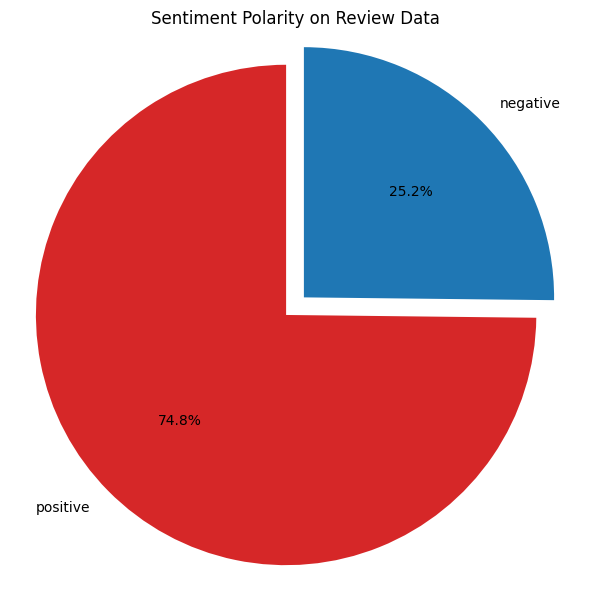

In [14]:
# Hitung jumlah masing-masing label polaritas
polarity_counts = clean_data['polarity'].value_counts()

colors = ['#1f77b4' if label == 'negative' else '#d62728' for label in polarity_counts.index] 
explode = [0.1 if label == 'positive' else 0 for label in polarity_counts.index]

plt.figure(figsize=(6, 6))
plt.pie(
    polarity_counts,
    labels=polarity_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode
)
plt.title('Sentiment Polarity on Review Data')
plt.axis('equal')
plt.tight_layout()
plt.show()

**Interpretasi Hasil** <br>
- Positif (positive) : Dari total 22.500 ulasan (74%), sebanyak 15637 ulasan memiliki sentimen positif. Ini berarti sebagian besar ulasan yang diterima oleh aplikasi bersifat positif dan banyak pengguna merasa puas dengan aplikasi tersebut.
- Negatif (negative) : Sebanyak 5262 ulasan (25.4%) memiliki sentimen negatif, menunjukkan bahwa sebagian kecil pengguna merasa tidak puas atau memiliki pengalaman buruk dengan aplikasi ini

# **Eksplorasi Label**

Setelah memberikan label sentimen pada data, langkah selanjutnya adalah melakukan eksplorasi terhadap distribusi dan karakteristik ulasan yang telah diberi label, baik yang positif maupun yang negatif.

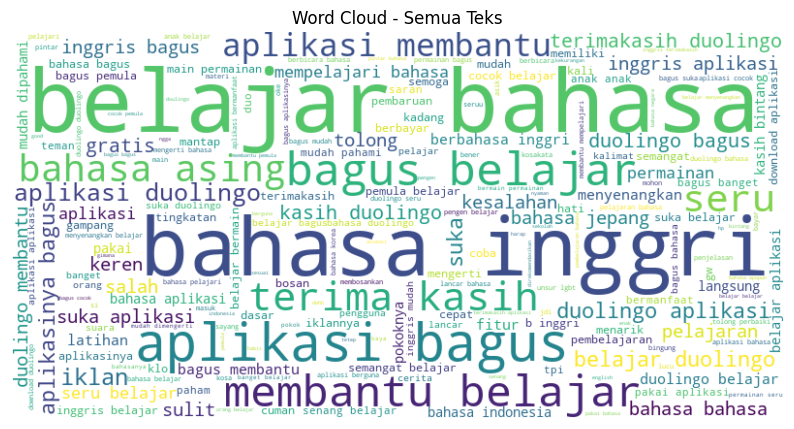

In [15]:
# Gabungkan semua teks dalam 'text_stopword' menjadi satu string
all_text = ' '.join([' '.join(map(str, text)) for text in clean_data['text_stopword']])

# Membuat Word Cloud untuk teks umum
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Visualisasi Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Semua Teks")
plt.show()

- "bahasa", "Inggris", "belajar", "aplikasi", dan "bagus" adalah kata-kata yang dominan.

- **Insight** <br>
Ini menunjukkan bahwa pengguna sangat fokus pada fitur pembelajaran bahasa, terutama bahasa Inggris, yang menjadi perhatian utama dalam ulasan mereka. Kata "aplikasi" dan "bagus" juga sering muncul, yang mencerminkan penilaian positif dari banyak pengguna.

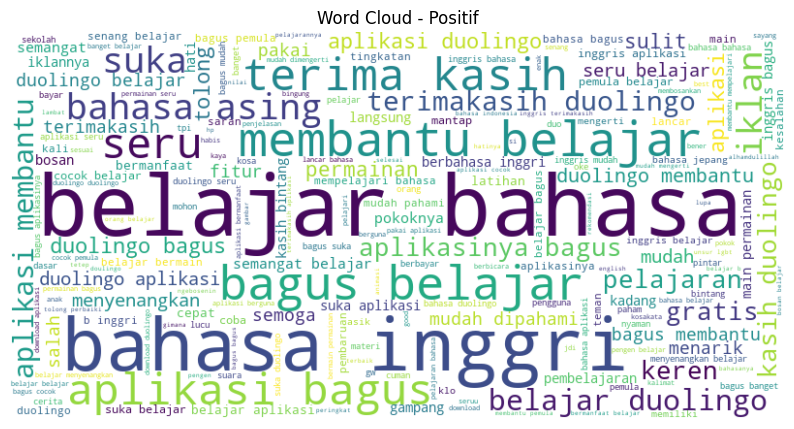

In [16]:
# Membuat Word Cloud untuk Teks Positif
positive_text = ' '.join([' '.join(map(str, text)) for text in clean_data[clean_data['polarity'] == 'positive']['text_stopword']])

if positive_text.strip():  # Memastikan teks tidak kosong
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud - Positif")
    plt.show()
else:
    print("Tidak ada teks positif untuk Word Cloud.")

- "belajar", "bahasa", "bagus", "terima kasih", "membantu", "duolingo".

- **Insight :**  <br>
Ulasan positif lebih menekankan pada manfaat aplikasi dalam belajar bahasa dengan kata-kata seperti "membantu" dan "terima kasih" yang menunjukkan kepuasan pengguna. Kata "duolingo" yang sering muncul menunjukkan bahwa aplikasi ini banyak disebutkan dalam konteks ulasan yang positif.

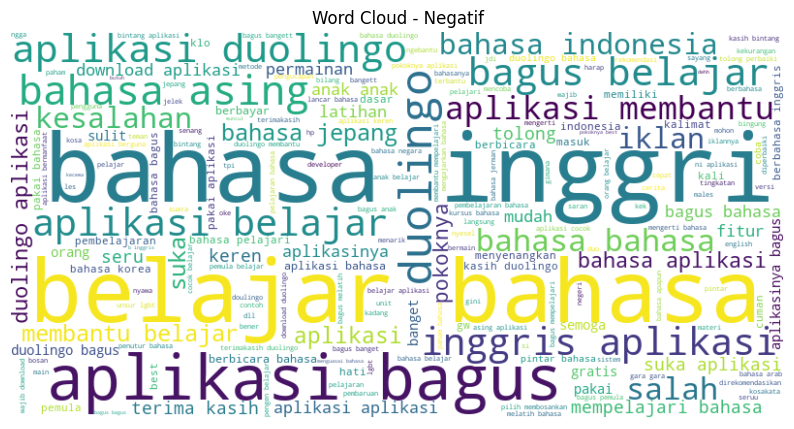

In [17]:
# Membuat Word Cloud untuk Teks Negatif
negative_text = ' '.join([' '.join(map(str, text)) for text in clean_data[clean_data['polarity'] == 'negative']['text_stopword']])

if negative_text.strip():  # Memastikan teks tidak kosong
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud - Negatif")
    plt.show()
else:
    print("Tidak ada teks negatif untuk Word Cloud.")

- "belajar", "bahasa", "aplikasi", "duolingo", "kesalahan", "sulit", "iklan".

- **Insight:** <br>
 Pada ulasan negatif, meskipun masih ada kata "aplikasi" dan "duolingo", kata-kata seperti "sulit", "kesalahan", dan "bagus" muncul dalam konteks keluhan atau masalah. Ini menunjukkan bahwa meskipun aplikasi ini dianggap bagus, ada beberapa masalah yang dikeluhkan pengguna, seperti kesulitan dalam belajar atau masalah teknis.

# **Data Splitting dan Ekstraksi Fitur dengan TF-IDF**

Dalam analisis teks untuk klasifikasi sentimen, kita membagi dataset menjadi data pelatihan dan data pengujian. Selain itu, kita mengekstrak fitur teks dengan menggunakan TF-IDF (Term Frequency-Inverse Document Frequency).

TF-IDF mengukur pentingnya sebuah kata dalam dokumen, dengan memberikan bobot lebih pada kata yang sering muncul dalam dokumen tetapi jarang muncul di dokumen lainnya, sehingga dapat menyoroti informasi yang relevan.

In [18]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_data['text_akhir']
y = clean_data['polarity']
 
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)
 
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
 
# Menampilkan hasil ekstraksi fitur
features_df
 
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# **Modelling**

Kita akan melakukan percobaan menggunakan empat jenis model dengan berbagai teknik ekstraksi fitur dan pembagian data yang berbeda.

- TF-IDF + SVM (80:20) <br>
Menggunakan TF-IDF untuk ekstraksi fitur dan SVM untuk klasifikasi sentimen. Model ini memiliki 80% data pelatihan dan 20% data pengujian.

- CountVectorizer + Naive Bayes (70:30) <br> 
Menggunakan CountVectorizer untuk ekstraksi fitur dan Naive Bayes untuk klasifikasi. Data dibagi 70% pelatihan dan 30% pengujian.

- Word2Vec + Random Forest (80:20) <br> 
Word2Vec untuk representasi kata dan Random Forest untuk klasifikasi. Pembagian data 80% pelatihan dan 20% pengujian.

- Logistic Regression + TF-IDF (70:30) <br>
Menggunakan Logistic Regression dengan TF-IDF untuk ekstraksi fitur dan pembagian data 70% pelatihan dan 30% pengujian.

In [19]:
# --- TF-IDF + SVM (80:20) ---
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(clean_data['text_akhir'])
y = clean_data['polarity']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
train_acc_svm = accuracy_score(y_train, svm.predict(X_train))
test_acc_svm = accuracy_score(y_test, svm.predict(X_test))

# --- CountVectorizer + Naive Bayes (70:30) ---
count_vect = CountVectorizer()
X_cv = count_vect.fit_transform(clean_data['text_akhir'])
y_cv = clean_data['polarity']
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.3, random_state=42)

nb_cv = MultinomialNB()
nb_cv.fit(X_train_cv, y_train_cv)
train_acc_nb = accuracy_score(y_train_cv, nb_cv.predict(X_train_cv))
test_acc_nb = accuracy_score(y_test_cv, nb_cv.predict(X_test_cv))

# --- Word2Vec + Random Forest (80:20) ---
tokenized = [text.split() for text in clean_data['text_akhir']]
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1)

def vectorize_text(text):
    words = text.split()
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.array([vectorize_text(text) for text in clean_data['text_akhir']])
y_w2v = clean_data['polarity']
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=42)

rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
rf_w2v.fit(X_train_w2v, y_train_w2v)
train_acc_rf = accuracy_score(y_train_w2v, rf_w2v.predict(X_train_w2v))
test_acc_rf = accuracy_score(y_test_w2v, rf_w2v.predict(X_test_w2v))

# --- Logistic Regression + TF-IDF (70:30) ---
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_lr, y_train_lr)
train_acc_lr = accuracy_score(y_train_lr, logreg.predict(X_train_lr))
test_acc_lr = accuracy_score(y_test_lr, logreg.predict(X_test_lr))

# --- Tampilkan hasil dalam bentuk tabel ---
hasil = pd.DataFrame({
    "Model": ["SVM", "Naive Bayes", "Random Forest", "Logistic Regression"],
    "Fitur": ["TF-IDF", "CountVectorizer", "Word2Vec", "TF-IDF"],
    "Split Data": ["80:20", "70:30", "80:20", "70:30"],
    "Train Accuracy": [train_acc_svm, train_acc_nb, train_acc_rf, train_acc_lr],
    "Test Accuracy": [test_acc_svm, test_acc_nb, test_acc_rf, test_acc_lr]
})

display(hasil)

,Model,Fitur,Split Data,Train Accuracy,Test Accuracy
0,SVM,TF-IDF,80:20,0.923381,0.912201
1,Naive Bayes,CountVectorizer,70:30,0.873949,0.803828
2,Random Forest,Word2Vec,80:20,1.000000,0.841627
3,Logistic Regression,TF-IDF,70:30,0.918928,0.907018


**Insight**
- Model SVM memberikan kinerja yang sangat baik dengan akurasi tinggi di kedua set data, baik pelatihan maupun pengujian. Ini menunjukkan bahwa model SVM mampu memisahkan kelas dengan sangat baik dan cukup generalisasi untuk data baru. TF-IDF sebagai fitur sangat membantu dalam mengekstraksi informasi penting dari teks.
- Model Naive Bayes juga memberikan hasil yang cukup baik, meskipun akurasinya sedikit lebih rendah dibandingkan dengan SVM. Naive Bayes cenderung lebih sensitif terhadap distribusi kata yang lebih sederhana dan CountVectorizer mengonversi teks menjadi fitur berbasis frekuensi kata. Akurasi pengujian yang sedikit lebih rendah dibandingkan pelatihan menunjukkan bahwa model mungkin mengalami sedikit overfitting atau kurang generalisasi pada data baru.
- Model Random Forest memiliki akurasi pelatihan yang sangat tinggi (100%), yang menunjukkan bahwa model berhasil mengingat dengan sangat baik data pelatihan. Namun, akurasi pengujian yang lebih rendah (84.16%) menunjukkan kemungkinan overfitting, di mana model sangat terfokus pada pola dalam data pelatihan dan kurang mampu generalisasi pada data uji. Word2Vec sebagai fitur mungkin menangkap hubungan kata-kata yang lebih mendalam tetapi bisa saja memberikan pola yang berlebihan pada data pelatihan.
- Logistic Regression memberikan kinerja yang sangat baik, hampir setara dengan SVM, dengan akurasi yang tinggi di kedua set data. Hal ini menunjukkan bahwa model ini cukup stabil dan mampu generalisasi dengan baik, mengingat bahwa perbedaan antara akurasi pelatihan dan pengujian sangat kecil. TF-IDF sebagai fitur juga memberikan kontribusi yang kuat dalam memisahkan sentimen dengan baik.

**Melakukan inference atau testing dalam file .ipynb**

In [22]:
# Contoh data baru untuk inferensi
new_data = [
    'Aplikasi Duolingo sangat membantu dalam belajar bahasa!', 
    'Saya merasa kecewa karena aplikasi sering mengalami crash.',
    'Secara keseluruhan, aplikasi ini cukup baik meskipun masih ada beberapa kekurangan.',
    'Fitur baru di aplikasi Duolingo sangat menyenangkan dan bermanfaat!'
]

# Transformasi data baru menggunakan vectorizer yang telah dilatih (misalnya TF-IDF)
new_data_tfidf = tfidf.transform(new_data)

# Prediksi dengan model yang telah dilatih, misalnya Naive Bayes
predictions = svm.predict(new_data_tfidf)

# Tampilkan hasil prediksi
for text, prediction in zip(new_data, predictions):
    print(f"Teks: {text} => Prediksi Sentimen: {prediction}")


Teks: Aplikasi Duolingo sangat membantu dalam belajar bahasa! => Prediksi Sentimen: positive
Teks: Saya merasa kecewa karena aplikasi sering mengalami crash. => Prediksi Sentimen: negative
Teks: Secara keseluruhan, aplikasi ini cukup baik meskipun masih ada beberapa kekurangan. => Prediksi Sentimen: negative
Teks: Fitur baru di aplikasi Duolingo sangat menyenangkan dan bermanfaat! => Prediksi Sentimen: positive
